# **Written Exam Economics Winter 2020-2021**
**Advanced Macroeconomics: Structural Vector Autoregressive (VAR) Analysis**


The topic for this pro ject examination is a small op en economy growth mo del. The purpose of the examination is to assess your understanding of structural vector autoregressive (VAR) models. Substantial emphasis will be placed on using your programming skills in MATLAB. Specifically, the examination assesses theoretical and practical knowledge of structural vector autoregressive mo dels within stationary and non-stationary frameworks including assessing empirical results, using different approaches to identify VAR models and be able to use MATLAB to generate empirical results. You can use any MATLAB functions that you have programmed yourself or any function uploaded to Absalon during the course except when otherwise stated. You are not allowed to use other programs or built-in MATLAB functions except for those that are specified in the questions b elow. The assignment requires some additional coding.

Most questions in the examination are applied, concerning the empirical example outlined below. When you answer these empirical questions, please explain and motivate your answers as detailed as possible, preferably with reference to the underlying theory. This exam focuses on a small open economy growth model. The steady-state solution to this particular model can be summarized by the following two equilibrium relations
$$\ln(Y_t)-\ln(I_t)= v_1$$
where $Y_t$ is GDP, $I_t$ is investments and $v_1$ is a constant, and
$$\ln(Y_t)−\ln(C_t)+(1−b)\ln(P_t)=v_2$$
where $C_t$ is total consumption, $b$ is the share of consumption of domestically produced goods in total consumption, Pt is the terms-of-trade and $v_2$ is a constant.

Assume that $x_t=\begin{pmatrix}\ln(P_t)&\ln(Y_t)&\ln(C_t)&ln(I_t)\end{pmatrix}=\begin{pmatrix}p_t&y_t&c_t&i_t\end{pmatrix}'$ and suppose that this vector is integrated of order one and ordered as in $x_t$ we find that the theoretical cointegration vector $\beta$ is given by
$$\beta'=
\begin{pmatrix}
0&1&0&−1\\
1−b&1&−1&0
\end{pmatrix}
$$

The assignment will guide you through an empirical analysis of the time series vector stated above including estimation and analysis of the cointegrated VAR model, identification of the structural cointegrated VAR model and robustness analysis.
Regarding the data for the exam paper, please note the following:
- All assignments are based on different data sets. You should use the data set (monthly data covering the period 1995:01-2015:01) located in the MATLAB file `1234.mat`, where 1234 is your exam number. This MATLAB file contains the data ($y$), the dates (dates) and the name of the variables (names). You can load this file into MATLAB directly using `load 1234.mat`. In case you cannot find your exam number, you can use the `1000.mat` file.
- To avoid that some data sets are more difficult to handle than others, the data sets are artificial (simulated from a known data generating process), and they behave, as close as possible, like actual data.

The proposed solution below is based on the data set `1000.mat`

<center>

### **Preamble**

</center>

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.font_manager import FontProperties
font_props = FontProperties(family='Times New Roman', size=10)
import seaborn as sns
sns.set_palette("pastel") 

from IPython.display import display, Math, clear_output
from sympy import Matrix
from sympy import latex, symbols

from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.tsatools import vech

from scipy.optimize import least_squares
from scipy.optimize import fsolve
import scipy.stats as stats
from scipy.stats import chi2
from scipy.stats import f

from pathlib import Path
import pandas as pd
import numpy as np
import random
import sys
import os

import warnings
warnings.filterwarnings("ignore", message="Setting `xtol` below the machine epsilon")
warnings.filterwarnings("ignore", message="Setting `gtol` below the machine epsilon")
warnings.filterwarnings("ignore", category=RuntimeWarning)

%load_ext autoreload
%autoreload 2

current_dir = Path.cwd()
sys.path.append(f"{current_dir}")


# Save output:
Python_path = None
LaTeX_path = None # LaTeX editor Texifier for macOS (https://www.texifier.com) highly recommended


pd.options.display.float_format = '{:.4f}'.format  # Ændrer til 4 decimale4

color_navy = '#{:02x}{:02x}{:02x}'.format(85, 108, 131)
colors_navy = ["#a5c6e2", "#80afd6", "#5b97ca", "#3b7fb9", "#2f6694", "#234c6f", "#17334a", "#0b1925"]
colors_pastel = sns.color_palette("pastel", 10)
colors_pastel

[(0.6313725490196078, 0.788235294117647, 0.9568627450980393),
 (1.0, 0.7058823529411765, 0.5098039215686274),
 (0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
 (1.0, 0.6235294117647059, 0.6078431372549019),
 (0.8156862745098039, 0.7333333333333333, 1.0),
 (0.8705882352941177, 0.7333333333333333, 0.6078431372549019),
 (0.9803921568627451, 0.6901960784313725, 0.8941176470588236),
 (0.8117647058823529, 0.8117647058823529, 0.8117647058823529),
 (1.0, 0.996078431372549, 0.6392156862745098),
 (0.7254901960784313, 0.9490196078431372, 0.9411764705882353)]

## $\text{Q1}$
The data is already in natural logarithms (real money balance and real GDP are in logs
whereas the money market rate is in p ercent). Plot the data and p erform graphical
analysis in order to assess the degree of integration of all four variables

In [1]:
# Data: 
result = pd.read_excel(f'{current_dir}/Data & Estimates/1000_2020.xlsx')

# Very important:
list_of_info = ["Dates: 1975-2020 (Quarterly)","Fed Funds Rate","Gross Domestic Product", "Consumption","Investments"]
list_of_info_latex = [r"$\ln(P)$", r"$\ln(Y)$",	r"$\ln(C)$",r"$\ln(I)$"]
K = len(result.drop(columns=["Dates"]).columns)

# Package/module:
from Structural_Vector_Autoregressive_Analysis import BaseClass

# Initialiser BaseClass med ønskede parametre
Base_initialize = BaseClass(LaTeX_path = None,                          # Can be None or LaTeX_path if LaTeX_path =! None it will save Tables/Plots to the LaTeX_path
                            Python_path = Python_path,                  # Path to Python folder
                            list_of_info_latex = list_of_info_latex,    # List of variable
                            list_of_info = list_of_info,                # List of names for each variable 
                            # Path to JCV.npy, PSSCV.npy and SigLevels.xlsx
                            path = f"{current_dir}/Data & Estimates/")    

from Structural_Vector_Autoregressive_Analysis import Initial_Tools as SVAR_IT
SVAR_IT = SVAR_IT(Base_initialize, date_column="Dates")

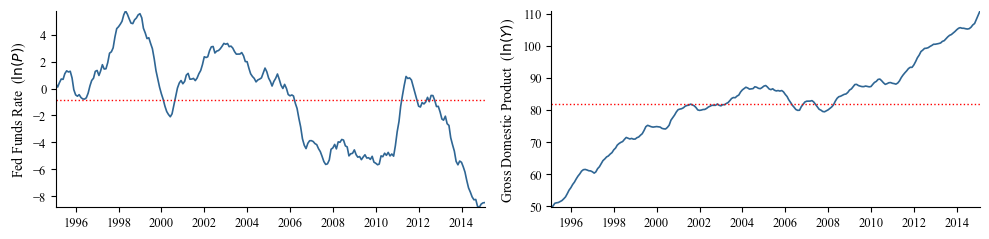

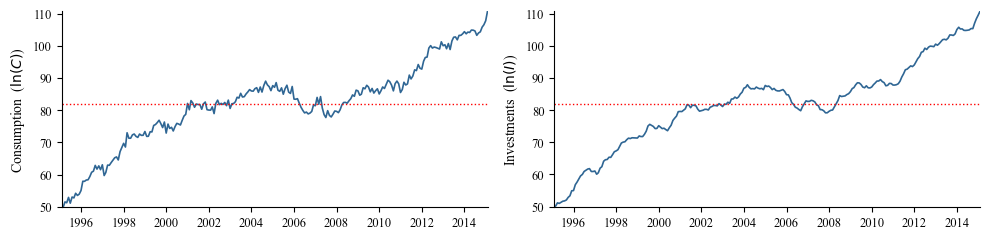

All variables have the same sample size: 241


,Mean,Median,Min,Max,Std. Dev.
Fed Funds Rate,-0.8707,-0.3450,-8.8069,5.7543,3.4577
Gross Domestic Product,81.9093,82.4787,49.7142,110.8159,13.2708
Consumption,81.8516,82.5467,49.9027,110.7081,12.8905
Investments,81.8822,82.5583,49.7939,110.7361,13.2463


In [2]:
SVAR_IT.Data_plot(result,Save=False)
SVAR_IT.Descriptive_Statistics(result, display_data=True)
y_clean_data = SVAR_IT.clean_data(result,display_data=False)

In [3]:
from Structural_Vector_Autoregressive_Analysis import Lag_Order_Determination as SVAR_LOD
SVAR_LOD = SVAR_LOD(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Diagnostic_Testing as SVAR_DT
SVAR_DT = SVAR_DT(Base_initialize, y_dataframe=y_clean_data)
 
from Structural_Vector_Autoregressive_Analysis import Univariate_Diagnostic_Testing as SVAR_UDT
SVAR_UDT = SVAR_UDT(Base_initialize, y_dataframe=y_clean_data)

from Structural_Vector_Autoregressive_Analysis import Testing_Cointegration as SVAR_TC
SVAR_TC = SVAR_TC(Base_initialize, y_dataframe=y_clean_data)

### The Vector Error Correction Model
Suppose that the three variables in the money demand function are either $I(1)$ or $I(0)$ and that the underlying data generating process is a trivariate Vector Autoregressive (VAR) model, 
$$x_t=\nu+A_1y_{t−1}+\ldots+A_py_{t−p}+u_t\tag{3}$$
where $x_t$ is defined above, $p$ is the lag length, $\nu$ is a constant term and $u_t$ is a vector of zero mean white noise process with covariance matrix $\Sigma_u$ such that $u_t\sim (0,\Sigma_u)$. Then we can rewrite the VAR model as the following Vector Error Correction (VEC) model
$$\Delta x_t=\nu+\Pi y_{t−1}+\Gamma_1\Delta x_{t−1}+\cdots+\Gamma_{p−1}\Delta x_{t−p+1}+u_t\tag{4}$$
where
$$
\Pi=−(I_4−A_1−\ldots−A_p)$$
and
$$Γ_i=−(A_{i+1}+\cdots+A_p)\quad\text{ for }~~i = 1,...,p −1$$

The rank of $\Pi$ is equal to the numb er of cointegration vectors $r$ and can be decomposed as a product of two $4\times r$ matrices of full rank, $\Pi=\alpha\beta'$ where α is the $4\times r$ adjustment coefficients
and $\beta$ is the $4\times r$ cointegration vectors

## $\text{Q2}$
Formulate a well-specified VEC model for $x_t$ similar to the VEC model above. Explain your workflow and how you argue for your choice of the numb er of autoregressive lags in the VEC model (and in its asso ciate VAR model)

In [4]:
_ = SVAR_LOD.Information_Criteria(maximum_lag_length=12, Trend=False, Show=True)

Lag,SIC,HQ,AIC
0,4.676639,4.640858,4.616662
1,-5.700658,-5.879564,-6.000546
2,-6.454113,-6.776144,-6.993912
3,-6.146992,-6.612148,-6.926702
4,-5.838397,-6.446677,-6.858018
5,-5.558088,-6.309493,-6.817620
6,-5.249019,-6.143549,-6.748461
7,-4.909885,-5.947539,-6.649237
8,-4.600833,-5.781612,-6.580096
9,-4.273301,-5.597205,-6.492475


In [5]:
_ = SVAR_LOD.Top_Down_Sequence(maximum_lag_length=4, Trend=False, Show=True)
# # Michael Bergman's computed log-likelihood differs from this one.
# # LR test and p-value is the same.

Lag,Log. Likelihood,LR test,p-value
0,1133.004868,,
1,-1448.342032,2581.346900,0.000000
2,-1721.597451,273.255418,0.000000
3,-1739.570294,17.972843,0.325490
4,-1755.078445,15.508151,0.487782


In [6]:
SVAR_LOD.Combined_Lag_Selection(maximum_lag_length=12, Trend = False, LaTeX=False)

Lag,SIC,HQ,AIC,LR Test
0,4.677,4.641,4.617,
1,-5.701,-5.880,-6.001,2463.341***
2,-6.454,-6.776,-6.994,259.481***
3,-6.147,-6.612,-6.927,16.609
4,-5.838,-6.447,-6.858,16.271
5,-5.558,-6.309,-6.818,22.749
6,-5.249,-6.144,-6.748,16.163
7,-4.910,-5.948,-6.649,9.278
8,-4.601,-5.782,-6.580,16.167
9,-4.273,-5.597,-6.492,11.935


## $\text{Q3}$
Test for multivariate auto correlation, heteroscedasticity and normality. Does your model satisfy the underlying assumptions? If the multivariate tests of auto correlation and ARCH reject the null hypotheses, apply univariate tests for auto correlation and ARCH in the residuals in each equation. You are allowed to use the built-in MATLAB functions lb qtest and archtest

In [7]:
SVAR_DT.Eigenvalue_Short_Table(maximum_lag_length=3, LaTeX=False)

Lag,"No Constant, No Trend",Constant Only,Trend Only,Constant and Trend
1,1.002602,0.998790,1.004490,0.992703
2,1.003367,1.001129,1.003216,0.959210
3,1.003114,1.000094,1.003022,0.964064


In [8]:
Constant = True
Trend = False
p = 2 # VAR Lags

_, _, _, residuals, _, SIGMA = SVAR_DT.VAR_estimation_with_exogenous(lags=p,Constant=Constant,Trend=Trend)
lag_h = 6
lags_q = 4

In [9]:
SVAR_DT.Multivariate_ARCH(residuals=residuals, lags_q=2)

,Test,Doornik_Hendry
0,Test statistic,204.8194
1,P-value,0.3927
2,Degrees of freedom,200.0000


In [10]:
SVAR_DT.Multivariate_Normality(residuals=residuals)

,Test,Doornik_Hansen,Lutkepohl
0,Joint test statistic:,2.7898,2.7056
1,P-value,0.9468,0.9515
2,Degrees of freedom,8.0000,8.0000
3,Skewness only,0.7473,1.2342
4,P-value,0.9454,0.8724
5,Kurtosis only,2.0425,1.4714
6,P-value,0.7279,0.8317


In [11]:
SVAR_DT.Multivariate_Portmanteau(residuals=residuals, lag_h=lag_h, lags=p)

,,Portmanteau,Modified Portmanteau
0,Test Statistic,67.7495,68.9528
1,p-value,0.3505,0.3136
2,Degrees of Freedom,64.0000,64.0000


In [12]:
SVAR_DT.Diagnostic_Table(residuals = residuals, 
                         Constant = Constant, 
                         lags_q = lags_q, 
                         lags_h = lag_h,
                         Trend = Trend, 
                         lags = p,
                         LaTeX = False)

,Doornik Hendry,Doornik Hansen,Lutkepohl,Portmanteau,Portmanteau Modified
Joint test,426.478,2.79,2.706,67.749,68.953
Skewness test,,0.747,1.234,,
Kurtosis test,,2.042,1.471,,


#### $$\text{Univariate Tests for {\small ARCH}, Normality, and Autocorrelation}$$

In [13]:
print("\nUnivariate ARCH Test - Het_ARCH")
display(SVAR_UDT.Univariate_ARCH_Test(residuals=residuals,lags=p))
print("\nUnivariate Normality Test - Jarque_Bera")
display(SVAR_UDT.Univariate_Normality_Test(residuals=residuals))
print("\nUnivariate Autocorrelation Test - Ljung-Box")
display(SVAR_UDT.Univariate_Autocorrelation_Test(residuals=residuals, lag_h=lag_h))

SVAR_UDT.Combined_Univariate_LaTeX(residuals=residuals,lags=p,lag_h=lag_h, LaTeX=False)


Univariate ARCH Test - Het_ARCH


,Hypothesis,P-Value,Test Statistic,Critical Value
Fed Funds Rate,0.0000,0.3270,2.2356,5.9915
Gross Domestic Product,0.0000,0.8736,0.2702,5.9915
Consumption,0.0000,0.1139,4.3450,5.9915
Investments,0.0000,0.1439,3.8771,5.9915



Univariate Normality Test - Jarque_Bera


,Hypothesis,P-Value,Test Statistic,Critical Value
Fed Funds Rate,0.0000,0.4948,1.4073,5.9915
Gross Domestic Product,0.0000,0.6250,0.9400,5.9915
Consumption,0.0000,0.7468,0.5839,5.9915
Investments,0.0000,0.4916,1.4204,5.9915



Univariate Autocorrelation Test - Ljung-Box


,Fed Funds Rate,Gross Domestic Product,Consumption,Investments
Lag 1,1.0906,0.2531,0.0196,0.0677
Lag 2,2.6458,0.3018,0.0374,0.1429
Lag 3,2.8128,0.3041,2.3837,0.3072
Lag 4,4.6951,0.4875,3.2762,0.9225
Lag 5,5.1358,0.5608,7.1693,1.3415
Lag 6,5.2174,0.8397,7.1764,3.2759


## $\text{Q4}$
For your preferred model, pro ceed by testing for cointegration using the MATLAB function jcitest. Explain your approach and how you find the numb er of cointegration vectors, that is, the rank $r$, in the system allowing for (i) a constant term in the cointegration vector and (ii) both a constant and a linear trend in the cointegration vector. Do you use different sources of information when determining the rank? If so, explain how you
arrive at your decision.


In [14]:
_ = SVAR_TC.Trace_Test(lags=p, p_value_threshold=0.05, LaTeX=False)

,1/H2/n,2/H1*/co,3/H1/ci,4/H*/cili,5/H/colo
0,179.574*** (λ=0.3481),186.571*** (λ=0.3487),176.448*** (λ=0.3485),183.522*** (λ=0.354),182.216*** (λ=0.3539)
1,77.32*** (λ=0.2426),84.1*** (λ=0.2426),74.044*** (λ=0.2426),79.102*** (λ=0.2501),77.818*** (λ=0.2501)
2,10.907* (λ=0.0401),17.687 (λ=0.0427),7.635 (λ=0.0313),10.321 (λ=0.0313),9.042 (λ=0.028)
3,1.123 (λ=0.0047),7.258 (λ=0.0299),0.034 (λ=0.0001),2.713 (λ=0.0113),2.247 (λ=0.0094)
Pantula,2,2,2,2,2


Sample: 239. Lag length: VAR: p=2 and VEC: p=1. Test statistic with Eigenvalue
in parentheses and the significance level as a superscript (10%, 5% and 1%).
Pantula principle at a 5%


In [15]:
cointegration_vectors, rank = SVAR_TC.Cointegration_Vectors(preferred_model=3, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=[1], 
                                rank=None,LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 3  |  Model: H1 ("ci") [constant in coint vec and linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 176.448 p-value: 0.001 ( *** ) and λ = 0.3485
     Rank: 1 LR: 74.044 p-value: 0.001 ( *** ) and λ = 0.2426
     Rank: 2 LR: 7.635 p-value: 0.5493 (  ) and λ = 0.0313

 \begin{pmatrix}  0.12929 & 1.00000 & -0.55189 & -0.44871 \end{pmatrix} 

 \begin{pmatrix}  0.01330 & 1.00000 & 0.04604 & -1.04605 \end{pmatrix} 


In [16]:
_, _ = SVAR_TC.Cointegration_Vectors(preferred_model=4, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=None, 
                                rank=None, LaTeX=True)

# Alternatively, for normalise_on_element use [1, 1, 1, 1] or [1,2,3,4],  
# but if so the length must equal 1 or K

Model: 4  |  Model: H* ("cili") [constant and linear trend in coint vec, linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 183.522 p-value: 0.001 ( *** ) and λ = 0.354
     Rank: 1 LR: 79.102 p-value: 0.001 ( *** ) and λ = 0.2501
     Rank: 2 LR: 10.321 p-value: 0.9106 (  ) and λ = 0.0313

 \begin{pmatrix}  0.32343 & 2.64686 & -1.60084 & -1.01773 \end{pmatrix} 

 \begin{pmatrix}  -0.12817 & -3.67277 & -0.07145 & 3.78392 \end{pmatrix} 


## $\text{Q5}$
Perform a test of the null hypothesis that there is no linear trend in the cointegration vectors.


In [17]:
LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bcon'], cons=SVAR_TC.zero_array(K+1)[K], model='H*', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "include a constant but not\na trend" if pval > threshold else "include both a constant\nand a trend"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}.\n"
      f"We {decision} the null that the trend in the cointegration \n"
      f"vector is zero, suggesting we should {conclusion}.")

print("\n   The freely estimated cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 4.3880 with a p-value of 0.1115.
We cannot reject the null that the trend in the cointegration 
vector is zero, suggesting we should include a constant but not
a trend.

   The freely estimated cointegration vector:


<IPython.core.display.Math object>

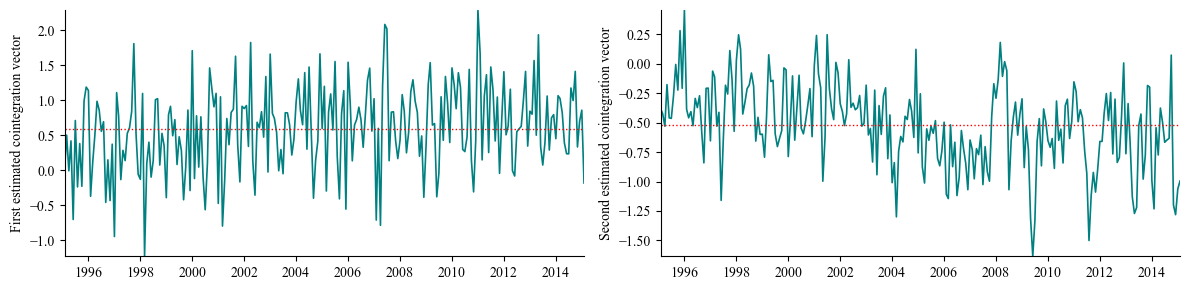

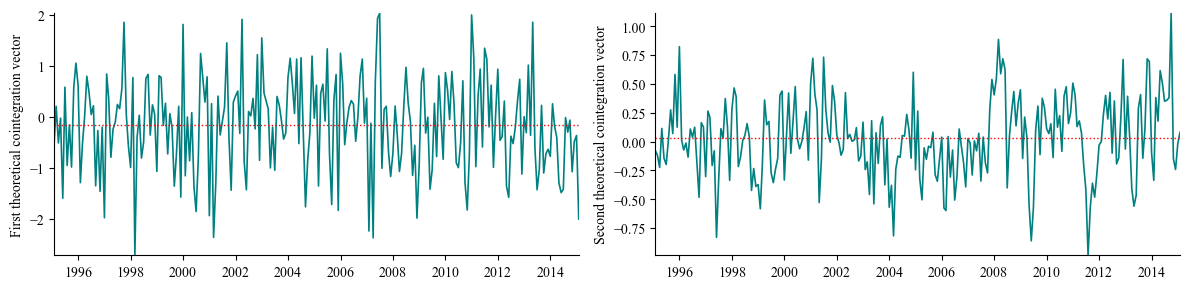

The correlation between coint1 and theo1 is: 0.9336
The correlation between coint2 and theo2 is:  0.828


In [47]:
b = 0.75
coint1 = np.dot(cointegration_vectors[0],np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab
coint2 = np.dot(cointegration_vectors[1],np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], coint1, f"First estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
SVAR_IT.setup_axis(axs[1], result['Dates'], coint2, f"Second estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
plt.tight_layout()
plt.show()

theo1 = np.dot(np.array([1-b, 1, -1, 0]),np.array(y_clean_data).T)
theo2 = np.dot(np.array([0, 1, 0, -1]),np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], theo1, f"First theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
SVAR_IT.setup_axis(axs[1], result['Dates'], theo2, f"Second theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
plt.tight_layout()
plt.show()

print(f"The correlation between coint1 and theo1 is: {round(np.corrcoef(coint1, theo1)[0, 1],4)}")
print(f"The correlation between coint2 and theo2 is:  {round(np.corrcoef(coint2, theo2)[0, 1],4)}")

## $\text{Q6}$
Impose your preferred rank and the preferred specification of the deterministic component in the cointegration vector found in the previous question and test hypotheses on the cointegration space using the MATLAB function jcontest. Test for exclusion, stationarity and weak exogeneity. Explain the meanings of these tests.

In [19]:
print(f"For rank = {rank} and lags = {p-1}")
SVAR_TC.Stationary_Exclusion_Exogeneity(rank=float(rank), lags=p, LaTeX=False)

# Long run time

For rank = 2 and lags = 1


,,Stationarity,,Exclusion,,Weak Exogeneity
Fed Funds Rate,,65.341***,,55.666***,,5.719*
Gross Domestic Product,,63.619***,,73.822***,,1.798
Consumption,,63.248***,,94.458***,,84.513***
Investments,,63.545***,,62.973***,,43.443***


## $\text{Q7}$
Interpret the unrestricted estimated cointegration vectors in light of the theoretical model above. Do you find plausible values of the parameters in the estimated cointegration vectors?


In [20]:
display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(cointegration_vectors)+r"'\end{equation}"))

<IPython.core.display.Math object>

## $\text{Q8}$
Test formally whether the theoretical cointegration vectors are in line with the information in the data using the MATLAB function jcontest. Estimate the parameter $b$ in the theoretical cointegration vector. Do you obtain a plausible value of $b$? Explain how your tests relate to the exclusion and stationarity tests

In [21]:
RR = np.transpose(np.array([[0,1,0,-1]], dtype=np.float64))

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bvec'], cons=RR, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.1

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 5.4790 with a p-value of 0.0646. This
suggests that we reject the null that the cointegration
relationships do not exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

In [22]:
RR = np.transpose(np.array([[1, 1, -1, 0]], dtype=np.float64))

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bvec'], cons=RR, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.1

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 64.4996 with a p-value of 0.0000. This
suggests that we reject the null that the cointegration
relationships do not exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

In [23]:
b=0.75
RR = np.transpose(np.array([[0, 1, 0, -1],[1-b, 1, -1, 0]], dtype=np.float64))

LRtest, pval, _, _, Brest, _, _, _, _ = \
    SVAR_TC.johcontest(r=rank, test=['bvec'], cons=RR, model='H1', lags=float(p-1), alpha=0.05)

threshold = 0.05

decision = "cannot reject" if pval > threshold else "reject"
conclusion = "do" if pval > threshold else "do not"
plural = "relationships" if int(rank) > 1 else "relationship"

print(f"The LR test statistic is {LRtest:.4f} with a p-value of {pval:.4f}. This\n"
      f"suggests that we {decision} the null that the cointegration\n"
      f"{plural} {conclusion} exist in the cointegration space")

print("\n   The cointegration vector:")

display(Math(r"\begin{equation}\beta="+SVAR_IT.To_Matrix(Brest.T)+r"'\end{equation}"))

The LR test statistic is 6.3721 with a p-value of 0.1730. This
suggests that we cannot reject the null that the cointegration
relationships do exist in the cointegration space

   The cointegration vector:


<IPython.core.display.Math object>

## $\text{Q9}$
Plot both the unrestricted and theoretical cointegration vectors. Interpret your results.

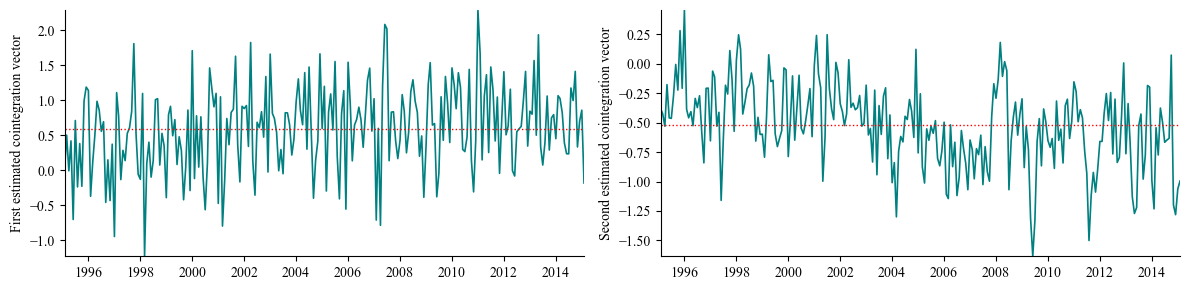

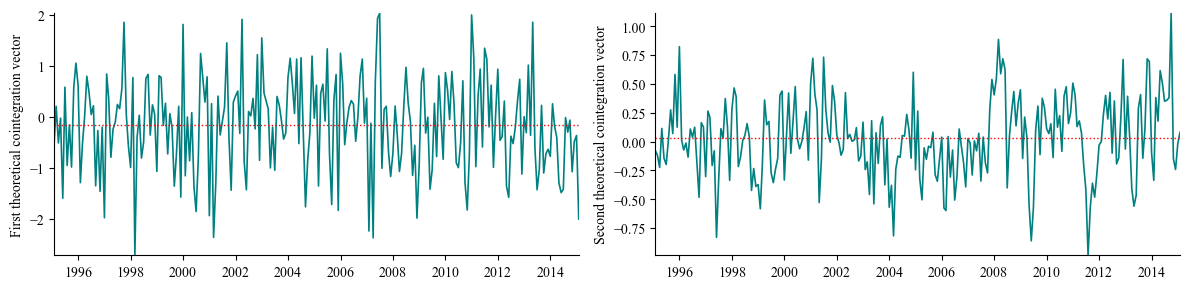

The correlation between coint1 and theo1 is: 0.9336
The correlation between coint2 and theo2 is:  0.828


In [48]:
coint1 = np.dot(cointegration_vectors[0],np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab
coint2 = np.dot(cointegration_vectors[1],np.array(y_clean_data).T)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], coint1, f"First estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
SVAR_IT.setup_axis(axs[1], result['Dates'], coint2, f"Second estimated cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
plt.tight_layout()
plt.show()

theo1 = np.dot(np.array([1-b, 1, -1, 0]),np.array(y_clean_data).T)
theo2 = np.dot(np.array([0, 1, 0, -1]),np.array(y_clean_data).T)     # need to multiply with -1 to match Matlab

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
SVAR_IT.setup_axis(axs[0], result['Dates'], theo1, f"First theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
SVAR_IT.setup_axis(axs[1], result['Dates'], theo2, f"Second theoretical cointegration vector", font_props, "Teal", mean_line=True,special_data_format=[False,10])
plt.tight_layout()
plt.show()

print(f"The correlation between coint1 and theo1 is: {round(np.corrcoef(coint1, theo1)[0, 1],4)}")
print(f"The correlation between coint2 and theo2 is:  {round(np.corrcoef(coint2, theo2)[0, 1],4)}")

## $\text{Q10}$
Split the sample into two equal sized sub-samples and perform tests for cointegration using the MATLAB function jcitest. Comment on the imp ortance of the sample length for these tests

In [25]:
y_clean_data_1 = y_clean_data.iloc[:len(y_clean_data)//2].copy().reset_index(drop=True)
y_clean_data_2 = y_clean_data.iloc[len(y_clean_data)//2:].copy().reset_index(drop=True)

for data in [y_clean_data_1, y_clean_data_2]:
    from Structural_Vector_Autoregressive_Analysis import Testing_Cointegration as SVAR_TC_TEMP
    SVAR_TC_TEMP = SVAR_TC_TEMP(Base_initialize, y_dataframe=data)
    
    cointegration_vectors, rank = SVAR_TC_TEMP.Cointegration_Vectors(preferred_model=3, 
                                lags=p, p_value_threshold=0.05, 
                                normalise_on_element=[1], 
                                rank=None,LaTeX=True)
    print("\n\n")
    

Model: 3  |  Model: H1 ("ci") [constant in coint vec and linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 100.097 p-value: 0.001 ( *** ) and λ = 0.3546
     Rank: 1 LR: 48.42 p-value: 0.001 ( *** ) and λ = 0.2801
     Rank: 2 LR: 9.636 p-value: 0.3528 (  ) and λ = 0.0561

 \begin{pmatrix}  0.11517 & 1.00000 & -0.50165 & -0.50401 \end{pmatrix} 

 \begin{pmatrix}  0.01309 & 1.00000 & 0.09831 & -1.09714 \end{pmatrix} 



Model: 3  |  Model: H1 ("ci") [constant in coint vec and linear trend in levels] 

  Rank determined automatically using the Pantula principle
     Rank: 0 LR: 106.669 p-value: 0.001 ( *** ) and λ = 0.4187
     Rank: 1 LR: 42.121 p-value: 0.0014 ( *** ) and λ = 0.2549
     Rank: 2 LR: 7.109 p-value: 0.601 (  ) and λ = 0.039

 \begin{pmatrix}  0.14047 & 1.00000 & -0.66259 & -0.32922 \end{pmatrix} 

 \begin{pmatrix}  0.04542 & 1.00000 & -0.01471 & -0.99154 \end{pmatrix} 





## $\text{Q11}$
Impose $r=2$ and the theoretical cointegration vector and re-estimate the VEC model using the full sample and using your preferred lag length found ab ove. Suggest an identification scheme including names of the four structural sho cks in the VAR/VEC system using long-run identification. If you cannot provide names for these shocks, try to explain how they affect the data under the maintained assumptions

In [26]:
from Structural_Vector_Autoregressive_Analysis import Identification_Restrictions_Cointegrated_SVAR as SVAR_IRC
SVAR_IRC = SVAR_IRC(Base_initialize,y_dataframe=y_clean_data, horizon = 60, lags=p, Constant=Constant, Trend=Trend, Exogenous=None)
phi = 0.75
Beta_theory = np.array([[0, 1, 0, -1],[1-b, 1, -1, 0]])

rank = 2

linear_combinations = None # {"Real Interest": [f"{list_of_info[2]} - {list_of_info[3]}"],
#                        "Monetary Base": [f"{list_of_info[4]} - {list_of_info[3]}"]
#                        }

print("\nLinear Combinations")
if not linear_combinations:
    linear_combinations = None
    print("  None")
else:
    for name, expressions in linear_combinations.items():
        for expr in expressions:
            print(f"  {name} = {expr}")

The estimated VAR model may be unstable due to largest absolute eigenvalue is greater than or equal to 1. 
Review the model specification for potential adjustments.
Max Eigenvalue = 1.001


Linear Combinations
  None


In [27]:
beta = SVAR_TC.Initilize_beta_vecm(lags=p,model=3, beta_theory=Beta_theory.T, rank=int(rank)).T
Beta, Betavec, SEBeta, tratioBeta, res, so, so_ml = SVAR_TC.LSKnownBeta(lags=p, beta=beta, model= 3)
Beta = Beta.T
tratioBeta = tratioBeta.T

GAMMA = Beta[:,0:K*(p-1)]       # first diff lags
alpha = Aest = Beta[:,K*(p-1):len(Beta.T)-1]   # speed of adjustment

tratioBeta_re = tratioBeta.reshape(-1, Beta.shape[1])
alpha_tratio = tratioBeta_re[:,K*(p-1):len(tratioBeta_re.T)-1]

print("Least Squares:")
print("Alpha estimates:\n",alpha.T,"\n")
print("Alpha t-ratios: \n",alpha_tratio.T)

alpha, Gamma, SigmaML, u = SVAR_IRC.VECMknown(beta=Beta_theory.T)

print("\nMaximum Likelihood ")
print("Alpha estimates: \n",alpha.T)

print("\nEquivalent: ~",np.allclose((alpha - Beta[:,K*(p-1):len(Beta.T)-1]),0))

Least Squares:
Alpha estimates:
 [[0.1920 0.0920 0.5908 0.6695]
 [0.0152 -0.0151 1.0091 0.0106]] 

Alpha t-ratios: 
 [[2.6132 1.2002 2.5453 6.4774]
 [0.4849 -0.4617 10.1670 0.2406]]

Maximum Likelihood 
Alpha estimates: 
 [[0.1920 0.0920 0.5908 0.6695]
 [0.0152 -0.0151 1.0091 0.0106]]

Equivalent: ~ True


## $\text{Q12}$
Write down the reduced form and structural form Common Trends model consistent with the VEC model. Show how these two representations are related. What is the consequence for the long-run multiplier if we assume that the rank $r=2$?

In [28]:
SVAR_TC.Identication_Scheme(rank)

Since the rank r = 2, there are 2 transitory/temporary shocks.
Thus, there are K-r = 2 permanent shocks.

    To identify the permanent shocks, we need (K-r)(K-r-1)/2 = 1 restrictions. (Upsilon)
    To identify the transitory shocks, we need r(r-1)/2 = 1 restrictions. (B^{-1}_0)


## $\text{Q13}$
Outline how the MATLAB solver can be used to imp ose long-run restrictions in your model

In [29]:
B_R = """[ * * * *
           * * * *
           * * 0 *
           * * * *]"""

U_R = """[ * 0 0 0
           * * 0 0
           * * 0 0 
           * * 0 0]"""

## $\text{Q14}$
Implement the identification scheme using the MATLAB solver. Check that the solver provides a valid identification and compute the variance-covariance matrix of the identified structural shocks. Please, provide the MATLAB code you are using to identify the shocks in the appendix. It must include a description of the restrictions you impose to identify the structural model

In [54]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=True)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K))#, xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))
Upsilon_solve = Xi @ B0inv
B0inv_solve = B0inv

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
0.28952 & -0.03118 & 0.09420 & -0.00258 \\
0.01885 & 0.31413 & 0.05193 & 0.01910 \\
0.13648 & 0.37700 & 0.00000 & -0.88000 \\
-0.07791 & 0.24902 & 0.34132 & 0.02950 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
0.70176 & -0.00000 & 0.00000 & -0.00000 \\
0.30146 & 1.21266 & 0.00000 & 0.00000 \\
0.47690 & 1.21266 & 0.00000 & -0.00000 \\
0.30146 & 1.21266 & 0.00000 & 0.00000 \\
\end{pmatrix}


## $\text{Q15}$
Estimate the structural VAR mo del and compute impulse resp onse functions (using the standard residual based recursive design bootstrap and IRF confidence bands computed using the delta method) and variance decomp osition (with bootstrap standard errors using Efron's percentile intervals). Focus only on the impulse responses of the data to
the two permanent shocks. You can show forecast error variance decomposition in either a table or in a graph. Interpret your results.


In [31]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd = SVAR_IRC.FEVD_IRF(irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=None)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=None)

In [32]:
IRFmat, VCmat = SVAR_IRC.VEC_Bootstrap(Bootstrap = True, 
                                       Bootstrap_type = "Wild", 
                                       Orthogonal = False, 
                                       iterations = None, 
                                       B0inv_R = B_R, 
                                       Upsilon_R = U_R, 
                                       rank = rank,
                                       n_trials=500, 
                                       Beta_theory = Beta_theory, 
                                       Umat = None, 
                                       Upsilon0 = None,
                                       estimator = "Numerical", 
                                       initial_guess = B0inv,
                                       linear_combinations = None) # None or linear_combinations

Initial settings and model checks
      Xi satisfies assumptions
      Identification of transitory shocks is valid
      Solver works correctly.

Numerical Solver (least_squares)

Trial: 500 of 505  |  Failures due to solver: 5 | Failures due to unstable eigenvalue: 0

  Bootstrap based on: 500 trials
  Estimator type in use: Numerical
  Bootstrap type in use: Wild

Total errors: 5
     Errors due to unstable replications: 0
     Errors due to Xi not satisfying assumptions: 0
     Errors due to solver failure to converge: 5


Impulse Response Function
Bootstrap (Wild) Confidence Intervals (Delta)


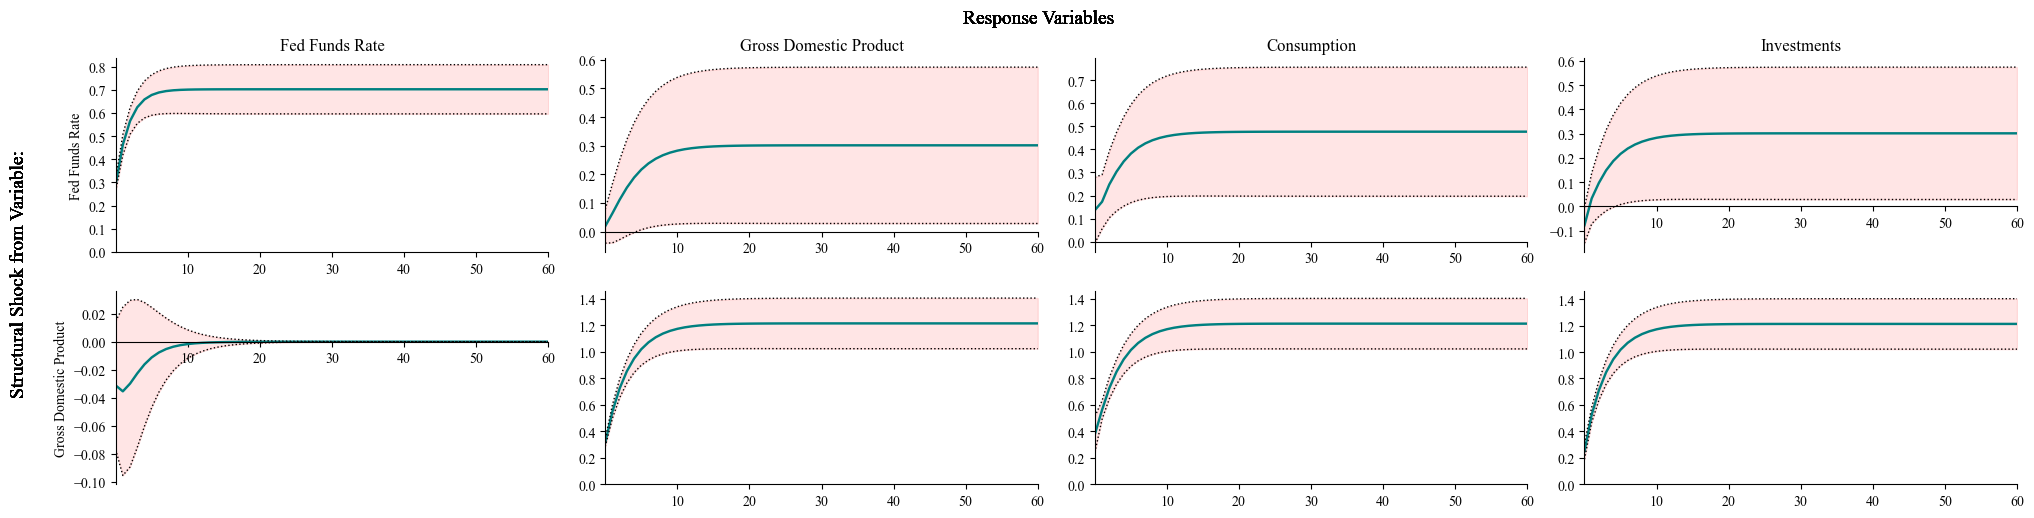

In [33]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = None, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta",  # or "Efron" can be extended.
    responses = [1,2,3,4],      # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2],         # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68],            # mulitple e.g. z_values=[95,68]
    Baseline = irf,             
    Info="Wild",                # VEC_Bootstrap() setting
    )

Forecast Error Variance Decomposition
Bootstrap (Wild) confidence intervals (Efron)


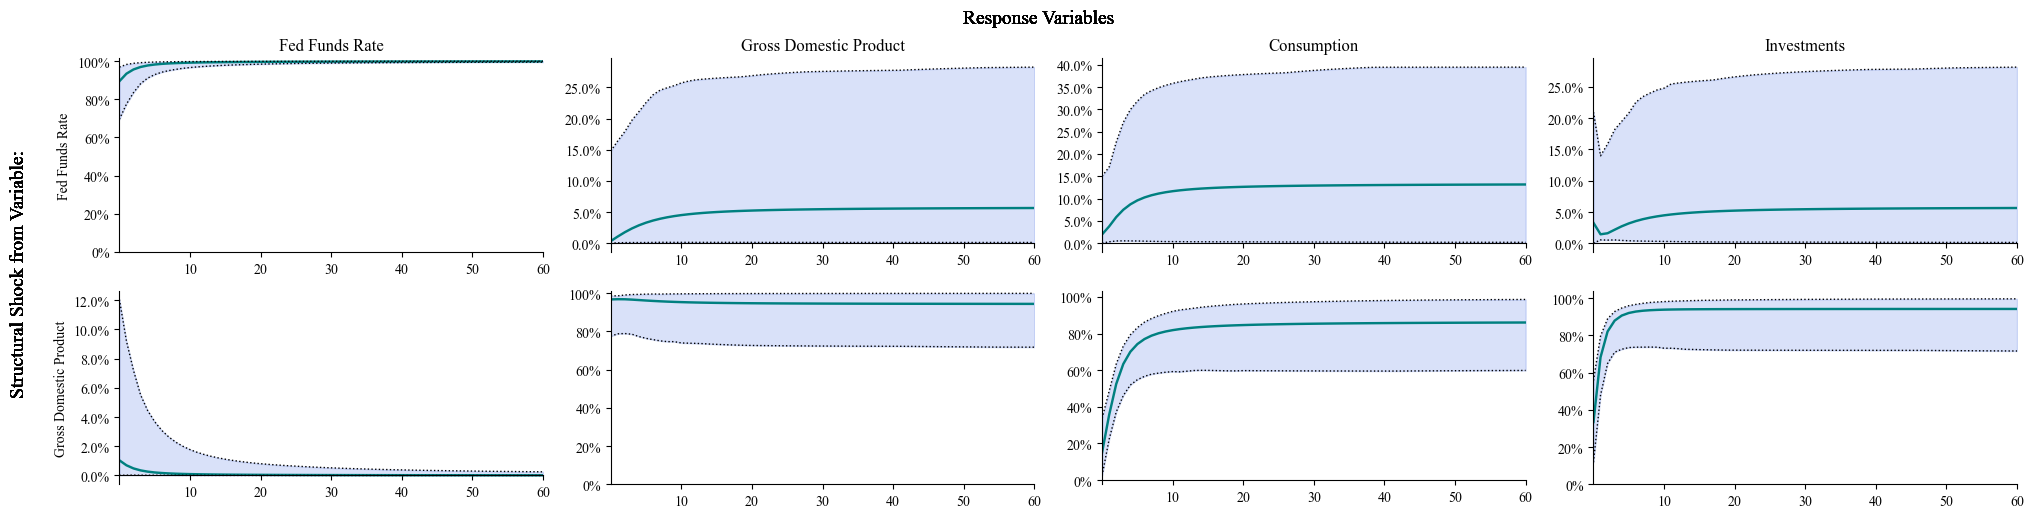

In [34]:
SVAR_IRC.FEVD_Combined_Plots(
    Bootstrap_Matrix = VCmat,
    confidence_type ="Efron", # can be extended.
    responses = [1,2,3,4], # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68], # mulitple e.g. z_values=[95,68]
    Baseline = fevd*100, 
    Info="Wild",
    )

## $\text{Q16}$
Instead of implementing the theoretical cointegration vector you can use the estimated cointegration vector still imp osing $r=2$. Identify the structural shocks using long-run restrictions and plot the implied impulse resp onses of the data together with confidence bands. Focus only on the effects of the permanent shocks. Compare your results to what you previously found using the theoretical cointegration vector.

If you fail computing the $B^{-1}_0$ matrix using the MATLAB solver, please use the `ident.p` file again. The code is generic and works for any cointegration vector. However, you cannot compare your results in any meaningful way


In [35]:
Beta_theory = np.array(cointegration_vectors)
alpha, Gamma, SigmaML, u = SVAR_IRC.VECMknown(beta=Beta_theory.T)

In [36]:
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=rank, beta = Beta_theory.T,ML=False)

invB0 = least_squares(lambda B0inv_flat: SVAR_IRC.Restrictions(B0inv_flat, B0inv_R=B_R, Upsilon_R=U_R, Xi=Xi, SIGMA=SIGMA,Beta=Beta_theory),
                        np.random.randn(K * K))# xtol=1e-1000000, gtol=1e-1000000, max_nfev=30000)

B0inv = invB0.x.reshape((K, K))
B0inv[:, B0inv.diagonal() < 0] *= -1

print("B_0^{-1}(B_0^{-1})'-\Sigma = 0        ",np.allclose((B0inv @ B0inv.T - SIGMA), 0))
print("\\beta'\\Upsilon = 0                    ",np.allclose((Beta_theory @ Xi @ B0inv), 0))
print("(B_0^{-1} \Sigma @ B_0^{-1})' = I_K   ",np.allclose((np.linalg.inv(B0inv) @ SIGMA @ np.linalg.inv(B0inv).T), np.eye(K)))

print("\nB^{-1}_0 =\n",SVAR_IT.To_Matrix(B0inv,short=False))
print("\n\\Upsilon =\n",SVAR_IT.To_Matrix(Xi @ B0inv,short=False))

B_0^{-1}(B_0^{-1})'-\Sigma = 0         True
\beta'\Upsilon = 0                     True
(B_0^{-1} \Sigma @ B_0^{-1})' = I_K    True

B^{-1}_0 =
 \begin{pmatrix}
0.28877 & -0.02713 & 0.09687 & 0.00714 \\
0.01576 & 0.31460 & 0.04759 & 0.02122 \\
0.16098 & 0.37658 & 0.00000 & -0.89053 \\
-0.08171 & 0.25473 & 0.34115 & 0.04083 \\
\end{pmatrix}

\Upsilon =
 \begin{pmatrix}
0.72546 & 0.00000 & -0.00000 & -0.00000 \\
0.31762 & 1.20425 & 0.00000 & 0.00000 \\
0.46088 & 1.22304 & 0.00000 & -0.00000 \\
0.34673 & 1.19638 & 0.00000 & 0.00000 \\
\end{pmatrix}


In [37]:
irf = SVAR_IRC.IRF(B0inv=B0inv,VEC=True,VAR=False,alpha=alpha,beta=Beta_theory.T)
fevd = SVAR_IRC.FEVD_IRF(irf)

IRF_result = SVAR_IRC.IRF_estimation(IRF_var=irf, list_of_info=list_of_info, normalise=None)
FEVD_result = SVAR_IRC.FEVD_estimation(FEVD_var=fevd, list_of_info=list_of_info, normalise=None)

In [38]:
IRFmat, VCmat = SVAR_IRC.VEC_Bootstrap(Bootstrap = True, 
                                       Bootstrap_type = "Wild", 
                                       Orthogonal = False, 
                                       iterations = None, 
                                       B0inv_R = B_R, 
                                       Upsilon_R = U_R, 
                                       rank = rank,
                                       n_trials=500, 
                                       Beta_theory = Beta_theory, 
                                       Umat = None, 
                                       Upsilon0 = None,
                                       estimator = "Numerical", 
                                       initial_guess = B0inv,
                                       linear_combinations = None) # None or linear_combinations

Initial settings and model checks
      Xi satisfies assumptions
      Identification of transitory shocks is valid
      Solver works correctly.

Numerical Solver (least_squares)

Trial: 500 of 505  |  Failures due to solver: 5 | Failures due to unstable eigenvalue: 0

  Bootstrap based on: 500 trials
  Estimator type in use: Numerical
  Bootstrap type in use: Wild

Total errors: 5
     Errors due to unstable replications: 0
     Errors due to Xi not satisfying assumptions: 0
     Errors due to solver failure to converge: 5


Impulse Response Function
Bootstrap (Wild) Confidence Intervals (Delta)


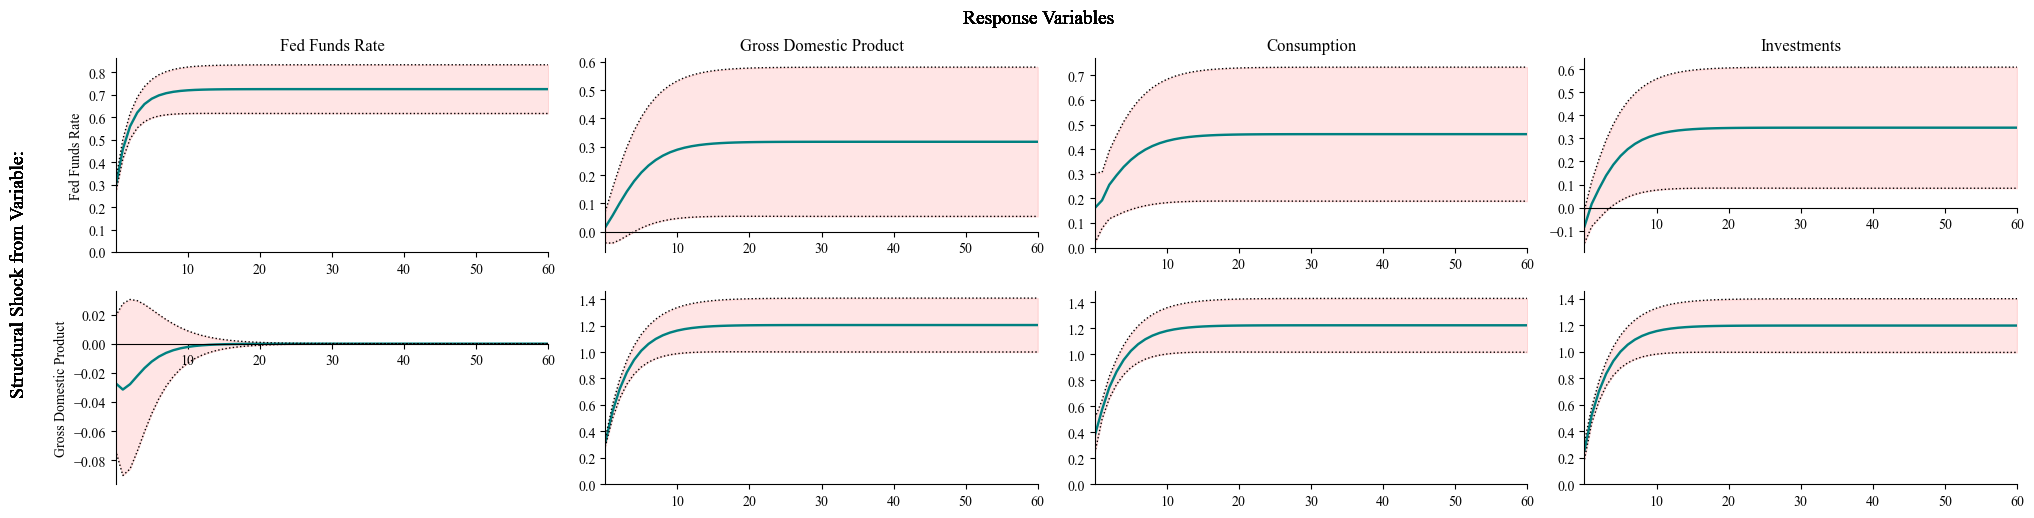

In [39]:
SVAR_IRC.IRF_Combined_Plots(
    linear_combinations = None, # None or linear_combinations
    Bootstrap_Matrix = IRFmat,
    confidence_type = "Delta",  # or "Efron" can be extended.
    responses = [1,2,3,4],      # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2],         # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68],            # mulitple e.g. z_values=[95,68]
    Baseline = irf,             
    Info="Wild",                # VEC_Bootstrap() setting
    )

Forecast Error Variance Decomposition
Bootstrap (Wild) confidence intervals (Efron)


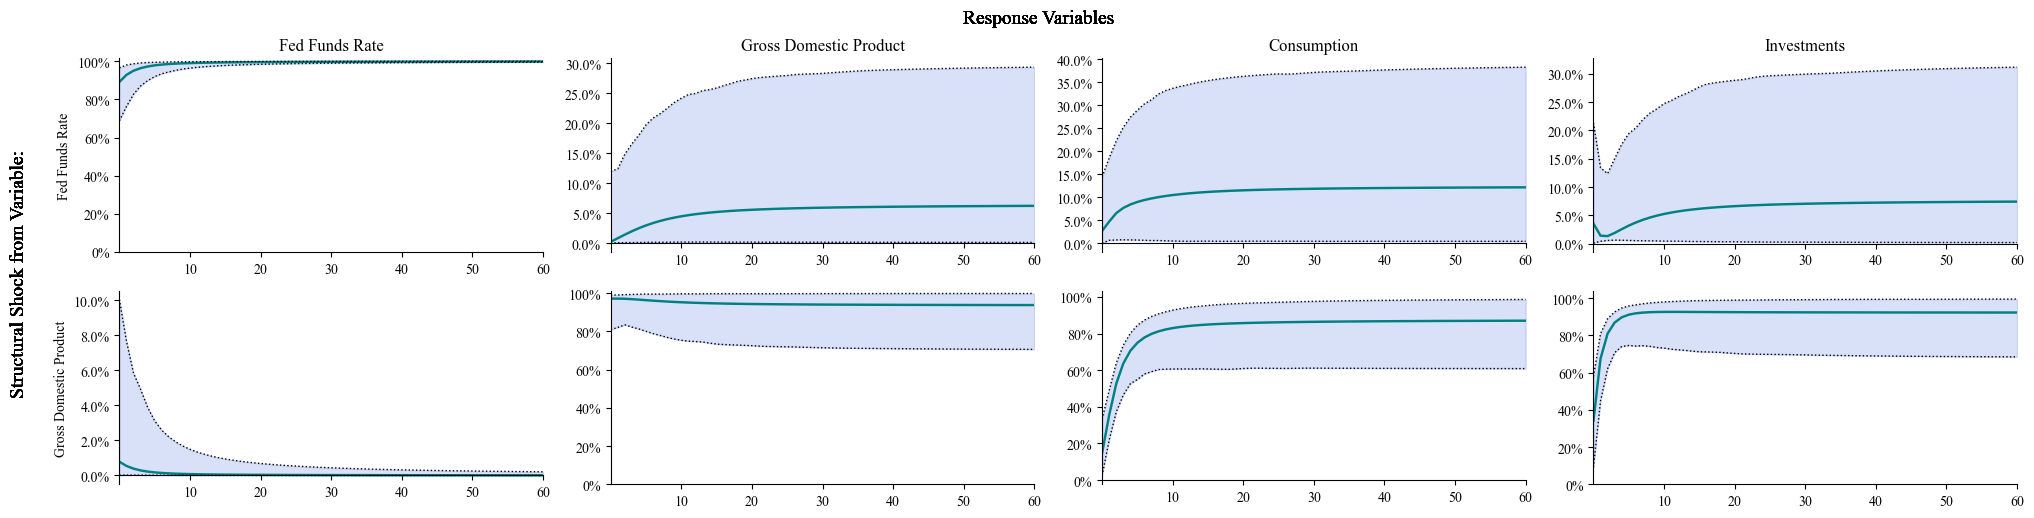

In [40]:
SVAR_IRC.FEVD_Combined_Plots(
    Bootstrap_Matrix = VCmat,
    confidence_type ="Efron", # can be extended.
    responses = [1,2,3,4], # None = All = [1,2,...,K] and can be any combination e.g [3,1]
    shocks = [1,2],  # None = All = [1,2,...,K] and can be any combination e.g [2]
    z_values = [68], # mulitple e.g. z_values=[95,68]
    Baseline = fevd*100, 
    Info="Wild",
    )

## $\text{Q17}$
An alternative to using the MATLAB solver to compute the $B^{-1}_0$ matrix is to use the approach suggested by Warne (1993). Outline this approach and show how the Warne approach can be used to identify the structural sho cks in your preferred VEC model. Discuss both the identification of permanent and transitory shocks.

In [41]:
Beta_theory = np.array([[0, 1, 0, -1],[1-b, 1, -1, 0]])
Aest, _, _, _ = SVAR_IRC.VECMknown(beta=Beta_theory.T)
Xi, SIGMA, _ = SVAR_IRC.Implement_identication(model = 3, rank=2.0, beta = Beta_theory.T, ML=True)

In [42]:
Upsilon0 = np.array([[1,0],
                     [0,1],
                     [1-b,1],
                     [0,1]])

print("Beta @ Upsilon =",(Beta_theory @ Upsilon0), " ~ ", "Valid" if np.all(Beta_theory @ Upsilon0 == 0) else "Not valid")

Beta @ Upsilon = [[0.0000 0.0000]
 [0.0000 0.0000]]  ~  Valid


In [55]:
Beta_theory_latex = Matrix(Beta_theory).evalf(3)
Upsilon0_latex = Matrix([[symbols(f"\\Upsilon_{{{i+1}{j+1}}}^0") for j in range(int(K))] for i in range(int(K-rank))])

def matrix_to_latex(matrix):
    return r"\begin{pmatrix}" + r"\\ ".join([" & ".join(map(str, row)) for row in matrix.tolist()]) + r"\end{pmatrix}"

latex_expr = (fr"\begin{{equation}} 0=\underset{{({Beta_theory_latex.shape[0]}\times{int(rank)})}}{{\underset{{{Beta_theory_latex.shape}}}{{\beta'}} \underset{{({int(K)}\times{int(rank)})}}{{\Upsilon_0}}}} = " 
              + matrix_to_latex(Beta_theory_latex) + matrix_to_latex(Upsilon0_latex.T) + "=" + matrix_to_latex(Beta_theory_latex * Upsilon0_latex.T) +r"\end{equation}").replace("*", "\\cdot")

display(Math(latex_expr.replace(", ","\\times ")))

<IPython.core.display.Math object>

In [56]:
pipit = np.dot(np.dot(np.dot(np.dot(np.linalg.inv(np.dot(Upsilon0.T,Upsilon0)),Upsilon0.T),Xi),SIGMA),np.dot(np.dot(np.linalg.inv(np.dot(Upsilon0.T,Upsilon0)),Upsilon0.T),Xi).T)            
pimat = np.linalg.cholesky(pipit)

Upsilon = np.dot(Upsilon0,pimat)                       
Fk = np.dot(np.dot(np.linalg.inv(np.dot(Upsilon.T,Upsilon)),Upsilon.T),Xi)
print('Fk matrix\n',Fk)

Umat = None

if Umat is None:
   Umat = np.zeros((int(rank), K))  # Antager en nulmatrix af størrelse r x K
   for i in range(1, int(rank) + 1):
      Umat[i - 1, K - i] = 1  # Python-indeks starter fra 0

if np.linalg.det(np.dot(Umat,Aest)) == 0:
   print('\n Identification of transitory shock is invalid')
else:
   print('\n Identification of transitory shocks is valid')

xi = np.dot(Aest,np.linalg.inv(np.dot(Umat,Aest)))  

i=0
while i < K:
   j=0
   while j< int(rank):
      if abs(xi[i,j]) < 1E-8: #just to make sure that elements are = 0
         xi[i,j] = 0
      j=j+1
   i=i+1

qr=np.linalg.cholesky(np.dot(np.dot(xi.T,np.linalg.inv(SIGMA)),xi))                   
Fr=np.dot(np.dot(np.linalg.inv(qr),xi.T),np.linalg.inv(SIGMA))
print('\n Fr matrix\n',Fr)

# Putting it all together to compute B0inv
invB0 = np.linalg.inv(np.vstack((Fk,Fr)))
invB0[:, invB0.diagonal() < 0] *= -1

print("\nB_0^{-1}\n",invB0)
print("")
print('\n(1) beta*Xi should be zero\n',np.dot(Beta_theory,Xi))
print('\n(2) beta*Upsilon_0 should be zero\n',np.dot(Beta_theory,Upsilon0))
print('\n(3) C(1)*B0^{-1} should be Upsilon~zeros(K,r)\n',np.dot(-Xi,invB0))
print('\nwhere Upsilon\n',Upsilon)
print('\n(4) Covariance matrix of structural shocks w_t should be I_K\n',np.dot(np.dot(np.linalg.inv(invB0),SIGMA),np.linalg.inv(invB0).T))
print('\nShould be diagonal\n',np.dot(np.dot(np.dot(np.dot(np.linalg.inv(qr),xi.T),np.linalg.inv(SIGMA)),xi),np.linalg.inv(qr.T))    )
print('\nThis compares Upsilon solver and closed form solution\n',Upsilon[:,0:K-int(rank)+1],'\n',Upsilon_solve[:,0:K-int(rank)+1],"\n")
Upsilon_Warne = np.dot(Xi,invB0)
B0inv_Warne = invB0

Fk matrix
 [[3.1098 1.1504 -0.0188 -1.0333]
 [-0.3629 3.4055 0.0610 -0.4179]]

 Identification of transitory shocks is valid

 Fr matrix
 [[0.9464 -2.3635 0.0474 3.0282]
 [-0.3268 -1.6374 1.1132 0.3393]]

B_0^{-1}
 [[0.2895 -0.0312 0.0942 -0.0026]
 [0.0189 0.3141 0.0519 0.0191]
 [0.1365 0.3770 0.0000 -0.8800]
 [-0.0779 0.2490 0.3413 0.0295]]


(1) beta*Xi should be zero
 [[-0.0000 -0.0000 -0.0000 0.0000]
 [0.0000 0.0000 -0.0000 0.0000]]

(2) beta*Upsilon_0 should be zero
 [[0.0000 0.0000]
 [0.0000 0.0000]]

(3) C(1)*B0^{-1} should be Upsilon~zeros(K,r)
 [[-0.7018 -0.0000 0.0000 0.0000]
 [-0.3015 -1.2127 -0.0000 -0.0000]
 [-0.4769 -1.2127 0.0000 -0.0000]
 [-0.3015 -1.2127 -0.0000 -0.0000]]

where Upsilon
 [[0.7018 0.0000]
 [0.3015 1.2127]
 [0.4769 1.2127]
 [0.3015 1.2127]]

(4) Covariance matrix of structural shocks w_t should be I_K
 [[1.0000 -0.0000 -0.0000 0.0000]
 [-0.0000 1.0000 -0.0000 0.0000]
 [-0.0000 -0.0000 1.0000 -0.0000]
 [0.0000 0.0000 -0.0000 1.0000]]

Should be diagonal
 

## $\text{Q18}$
Code this identification and compute the implied $B^{-1}_0$ matrix and show that it is identical to the one found by the solver. Please, provide the code you are using in the appendix.

In [58]:
print("Upsilon  ≈  Upsilon (solve)   ~  ",np.allclose(Upsilon_Warne, Upsilon_solve))
print("B_0^{-1} ≈  B_0^{-1} (solve)  ~  ",np.allclose(B0inv_Warne, B0inv_solve))

print("\nDifference (Maximum)")
print(f"    B_0^{{-1}}:  {np.max(B0inv_Warne - B0inv_solve):.25f}")
print(f"    Upsilon:   {np.max(Upsilon_Warne - Upsilon_solve):.25f}")

def matrix(matrix, name):
    string = f"$$\n{name} = \\begin{{pmatrix}}\n"
    rows, cols = matrix.shape
    for i in range(rows):
        row = " & ".join([f"{matrix[i, j]:.10f}" for j in range(cols)])
        string += row + " \\\\\n"
    string += "\\end{pmatrix}\n$$"
    return string

display(Math(matrix(B0inv_solve, "\\underset{(\\textit{Solver})}{B_{0}^{-1}}")))
display(Math(matrix(B0inv_Warne, "\\underset{(\\textit{Warne})}{B_{0}^{-1}}")))
print("")
display(Math(matrix(Upsilon_solve, "\\underset{(\\textit{Solver})}{\\Upsilon_{0}}")))
display(Math(matrix(Upsilon_Warne, "\\underset{(\\textit{Warne})}{\\Upsilon_{0}}")))

Upsilon  ≈  Upsilon (solve)   ~   True
B_0^{-1} ≈  B_0^{-1} (solve)  ~   True

Difference (Maximum)
    B_0^{-1}:  0.0000000000134374178450969
    Upsilon:   0.0000000000002038369473212


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [46]:
if "True" == "True":
    print(matrix(B0inv_solve,   r"\underset{(\textit{Solver})}{B_{0}^{-1}}"),"\n")
    print(matrix(B0inv_Warne,   r"\underset{(\textit{Warne})}{B_{0}^{-1}}" ),"\n")
    print(matrix(Upsilon_solve, r"\underset{(\textit{Solver})}{\Upsilon_0}"),"\n")
    print(matrix(Upsilon_Warne, r"\underset{(\textit{Warne})}{\Upsilon_0}" ),"\n")

$$
\underset{(\textit{Solver})}{B_{0}^{-1}} = \begin{pmatrix}
0.2895245094 & -0.0311829133 & -0.0941971133 & -0.0025836871 \\
0.0188503307 & 0.3141252844 & -0.0519260461 & 0.0191013943 \\
0.1364776601 & 0.3769977745 & 0.0000000000 & -0.8800027018 \\
-0.0779141426 & 0.2490161562 & -0.3413194238 & 0.0294975812 \\
\end{pmatrix}
$$ 

$$
\underset{(\textit{Warne})}{B_{0}^{-1}} = \begin{pmatrix}
0.2895245094 & -0.0311829133 & 0.0941971133 & -0.0025836871 \\
0.0188503307 & 0.3141252844 & 0.0519260462 & 0.0191013942 \\
0.1364776601 & 0.3769977745 & 0.0000000000 & -0.8800027018 \\
-0.0779141426 & 0.2490161561 & 0.3413194239 & 0.0294975812 \\
\end{pmatrix}
$$ 

$$
\underset{(\textit{Solver})}{\Upsilon_0} = \begin{pmatrix}
0.7017608585 & 0.0000000000 & -0.0000000000 & 0.0000000000 \\
0.3014618309 & 1.2126649529 & -0.0000000000 & -0.0000000000 \\
0.4769020455 & 1.2126649529 & -0.0000000000 & -0.0000000000 \\
0.3014618309 & 1.2126649529 & -0.0000000000 & -0.0000000000 \\
\end{pmatrix}
$$ 

$$
\unde